In [60]:
import pandas as pd
import dask as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats




In [61]:
df = pd.read_csv('../data/JV_data_dist.csv')

#Filter data
df = df[df['mfgf'] == "Yes"]
df = df[df['sic'].str.contains('3711') == True]
df = df[df['public_count'] >= 1]
df = df[df['nump'] == 2]
df = df[df['emp_min'] >= 100 ]



#Recode variables
df['pdynamic'] = df['pdynamic'].map({'new_entrant': 1, 'incumbent': 0})
df['rndf'] = df['rndf'].map({"Yes": 1, "No": 0})
df["snation_partal"] = df["snation_partal"].map({"Y": 1, "N": 0})
df['jvf'] = df['jvf'].map({'Yes': 1, 'No': 0})

df = df.reset_index(drop=True)

In [62]:
cols = ['ddist_year', 'public_count', 'rndf', 'snation_partal', 'emp_min', 'avg_emp_pp', 'pdynamic']

y = df['jvf']
X = df[cols]
X_constant = sm.add_constant(X, prepend=False)

In [63]:
y.isna().sum()

0

1. Appropriate outcome type: Satisfied since outcome is either new entrent or incumbent
2. Linearity of independent variables and log-odds: Satisfied
3. No strongly influential outliers: Satisfied
4. Absence of multicollinearity: Satisfied since it's a simple Logistical Reg. with one IV
5. Independence of observations: Satisfied since data is time series observations
6. Sufficiently large sample size: Satisfied since the dataset consists of >500 observations

### Assumption 2: Continuous IV is linearly related to the log odds

In [64]:
#Prepped data to R 
dfR = df.copy()
dfR['ddist_year'] = abs(dfR['ddist_year'])
dfR = dfR.drop(dfR[dfR['ddist_year'] == 0].index)
dfR['ddist_year'] = dfR['ddist_year']

dfR[['pdynamic', 'ddist_year', 'public_count']].to_csv('../data/prepped-r.csv', index=False)

#### Results from R:

p-value = 0.229, which is >0.05 (meaning that it is statistically not significant)
This means that there is linearity in the Discontinuity Distance feature, and the assumption has not violated

### Box Tidwell

In [65]:
df_lt = df.copy()  # lt = logit transform
df_lt['ddist_year'] = abs(df_lt['ddist_year'])
df_lt = df_lt.drop(df_lt[df_lt['ddist_year'] == 0].index)

# Define continuous variables
continuous_var = ['ddist_year', 'public_count', 'emp_min', 'avg_emp_pp']

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in continuous_var:
	df_lt['Log_' + var] = df_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

cols_to_keep = continuous_var + df_lt.columns.tolist()[-len(continuous_var):]

# Redefine independent variables to include interaction terms
X_lt = df_lt[cols_to_keep]
y_lt = df_lt['jvf']

# Add constant
X_lt_constant = sm.add_constant(X_lt, prepend=False)
  
# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_lt, X_lt_constant, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    jvf   No. Observations:                  169
Model:                            GLM   Df Residuals:                      161
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -93.761
Date:                Fri, 17 Jun 2022   Deviance:                       187.52
Time:                        22:03:03   Pearson chi2:                     166.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07013
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ddist_year           0.5426      1.217  

Non statistically significant, so the assumption is not violated.

#### Visual check

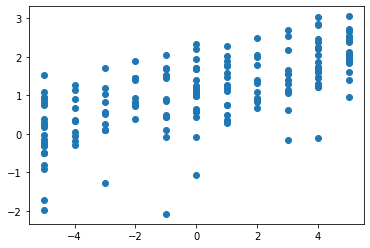

In [66]:
# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X_constant, family=families.Binomial()).fit()
predicted = logit_results.predict(X_constant)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x=X_constant['ddist_year'].values, y=log_odds);
plt.show()

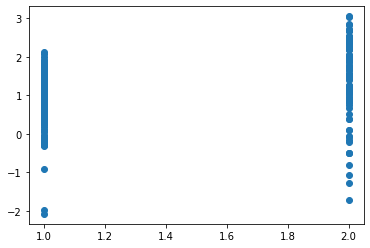

In [67]:
plt.scatter(x=X_constant['public_count'].values, y=log_odds);
plt.show()

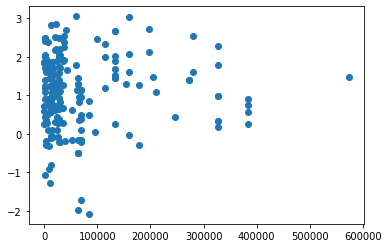

In [68]:
plt.scatter(x=X_constant['emp_min'].values, y=log_odds);
plt.show()

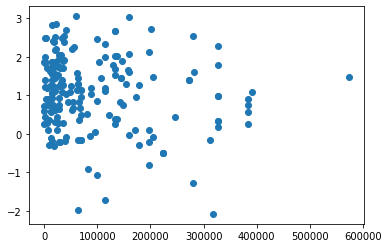

In [69]:
plt.scatter(x=X_constant['avg_emp_pp'].values, y=log_odds);
plt.show()

### Assumption 3: Lack of outliers

Cook’s Distance is an estimate of the influence of a data point. It takes into account both the leverage and residual of each observation. Cook’s Distance is a summary of how much a regression model changes when the ith observation is removed.
A general rule of thumb is that any observation with a Cook’s distance greater than 4/n (where n = total observations) is considered to be influential (https://www.statology.org/cooks-distance-python/ and https://www.scikit-yb.org/en/latest/api/regressor/influence.html?highlight=cook#module-yellowbrick.regressor.influence), though there are even more generic cutoff values of >0.5-1.0.
For outliers, we can use the absolute standardized residuals to identify them (std resid > 3)

In [70]:
logit_model = GLM(y, X_constant, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    jvf   No. Observations:                  195
Model:                            GLM   Df Residuals:                      187
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -100.99
Date:                Fri, 17 Jun 2022   Deviance:                       201.99
Time:                        22:03:05   Pearson chi2:                     192.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1427
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ddist_year         0.1607      0.055      2.

In [71]:
# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df

,cooks_d,std_resid
0,0.001879,0.621080
1,0.002769,0.835383
2,0.001379,0.466690
3,0.020667,1.734939
4,0.007981,0.919459
...,...,...
190,0.000408,0.398396
191,0.000170,0.259437
192,0.000162,0.266321
193,0.003615,0.626937


In [72]:
# Set Cook's distance threshold
cook_threshold = 4 / len(X)
print(f"Threshold for Cook Distance = {cook_threshold}")

Threshold for Cook Distance = 0.020512820512820513


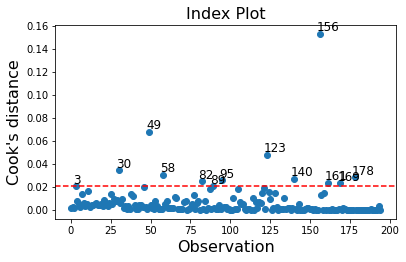

In [73]:
# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y=cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

In [74]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(X)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 6.7%


In [75]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(X)),1)
print(f'Proportion of highly influential outliers = {prop_extreme}%')

Proportion of highly influential outliers = 0.5%


In [76]:
# Display top 5 most influential outliers
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
178,0.028532,3.484972


In [81]:
X.iloc[178]

ddist_year            5.0
public_count          2.0
rndf                  0.0
snation_partal        0.0
emp_min           28850.0
avg_emp_pp        33233.5
pdynamic              0.0
Name: 178, dtype: float64

There are not outliers that can alter the reliability of the Logistical Regression Model

## Logistic Regression Model

In [78]:
model = smf.logit(formula="pdynamic~ ddist_year", data= df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.640115
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               pdynamic   No. Observations:                  195
Model:                          Logit   Df Residuals:                      193
Method:                           MLE   Df Model:                            1
Date:                Fri, 17 Jun 2022   Pseudo R-squ.:                 0.06148
Time:                        22:03:07   Log-Likelihood:                -124.82
converged:                       True   LL-Null:                       -133.00
Covariance Type:            nonrobust   LLR p-value:                 5.255e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3661      0.153     -2.390      0.017      -0.666      -0.066
ddist_year     0.1791      0.046      3.879      0.000       0.089       0.270
==============================================================================
"""

In [79]:
logit_model = GLM(y, X_constant, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    jvf   No. Observations:                  195
Model:                            GLM   Df Residuals:                      187
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -100.99
Date:                Fri, 17 Jun 2022   Deviance:                       201.99
Time:                        22:03:07   Pearson chi2:                     192.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1427
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ddist_year         0.1607      0.055      2.